In [1]:
%matplotlib inline

In [216]:
from enum import Enum
from tqdm.notebook import tqdm
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.datacollection import DataCollector
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Line
from bokeh.models.annotations import Legend
from bokeh.palettes import Category10
import matplotlib.pyplot as plt
import pandas as pd
import panel as pn
import math
import itertools
pn.extension()

# Mesa
> Mesa is a modular framework for building, analyzing and visualizing **agent-based models**.

[Documentation](https://mesa.readthedocs.io/en/master/overview.html)

# Introduction

The simulation is composed of the following components:
- `Model` class - representing the model.
- `Agent` class - representing the agent.
- `Scheduler` class - agent activation strategy
- `step` method - simulation logic

In the simulation we will have a continouous space. Agents will move within it and infect other agents.

# Simulation model

In [42]:
class State(Enum):
    UNAFFECTED = 0
    INFECTED = 1
    RECOVERED = 2
    DEAD = 3

### _Ex. 1. Warmup_

In [ ]:
def change_position(pos, speed, heading):
    x, y = pos
    return # TODO 1: return new position

In [26]:
def change_position(pos, speed, heading):
    x, y = pos
    return (
        x + speed * math.sin(heading),
        y + speed * math.cos(heading)
    )

## Agent

### _Ex. 2. Agent implementation_

In [233]:
class EpidemicAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, state):
        super().__init__(unique_id, model)
        self.state = state
        self.infection_probability = model.infection_p
        self.infection_radius = model.infection_r
        self.speed = model.initial_speed
        self.heading = self.random.uniform(0, 2 * math.pi)
        self.time_infected_min = model.infection_time_min
        self.time_infected = self.random.uniform(0, self.time_infected_min) if state == State.INFECTED else 0
        self.solution_p = model.infection_end_p
        self.death_p = model.death_p

    def move(self):
        # Move agent
        new_pos = change_position(self.pos, self.speed, self.heading)
        self.model.grid.move_agent(self, new_pos)
        # Update velocity
        self.speed += self.random.uniform(-3, 3)
        self.heading += self.random.uniform(-math.pi/4, math.pi/4)
    
    def infect(self):
        # TODO 2: Select agents within `infection_radius`
        # TODO 2: Infect others with `infection_probability`
        
        # DONE:
        # Select agents within radius
        mates = self.model.grid.get_neighbors(self.pos, self.infection_radius, include_center=False)
        for other in mates:
            # Infect agent with probability
            if self.random.random() < self.infection_probability:
                other.become_infected()

    def become_infected(self):
        if self.state == State.UNAFFECTED:
            self.state = State.INFECTED
            self.time_infected = 0
    
    def try_die_or_recover(self):
        # TODO 5: implement recovery or death after no sooner then `time_infected_min`
        # TIP: use the following fields: `time_infected`, `time_infected_min`, `solution_p`, `death_p`
        # TIP: use `die` and `recover` methods
        pass
    
        # DONE:
#         if self.time_infected > self.time_infected_min and self.random.random() < self.solution_p:
#             if self.random.random() < self.death_p:
#                 self.die()
#             else:
#                 self.recover()

    def die(self):
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
        self.state = State.DEAD

    def recover(self):
        self.state = State.RECOVERED

    def step(self):
        # TODO 2: Move agent, before it infects
        # DONE:
        self.move()
        
        if self.state == State.INFECTED:
            self.time_infected += 1
            self.infect()
            self.try_die_or_recover()

In [3]:
def compute_alive(model):
    return # TODO: return number of alive agents

In [77]:
def compute_alive(model):
    return len(model.schedule.agents)

In [3]:
def compute_sick(model):
    return # TODO: return number of sick agents

In [79]:
def compute_sick(model):
    return len([a for a in model.schedule.agents if a.state == State.INFECTED])

In [155]:
def compute_dead(model):
    return model.num_agents - compute_alive(model)

In [ ]:
def compute_recovered(model):
    return len([a for a in model.schedule.agents if a.state == State.RECOVERED])

## Model

### Ex. 3. Model implementation

In [250]:
class EpidemicModel(Model):
    """A model with some number of agents."""
    def __init__(self,
                 N,
                 initial_infection_p,
                 infection_p,
                 infection_r,
                 infection_time_min,
                 infection_end_p,
                 death_p,
                 initial_speed):
        x_max, y_max = 1000, 1000
        self.num_agents = N
        
        self.initial_infection_p = initial_infection_p
        self.infection_p = infection_p
        self.infection_r = infection_r
        self.infection_time_min = infection_time_min
        self.infection_end_p = infection_end_p
        self.death_p = death_p
        self.initial_speed = initial_speed
        
        self.grid = ContinuousSpace(x_max, y_max, torus=True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            is_sick = self.random.random() < initial_infection_p
            a = EpidemicAgent(i, self, state=State.INFECTED if is_sick else State.UNAFFECTED)
            self.schedule.add(a)
            
            x = self.random.uniform(0, self.grid.width)
            y = self.random.uniform(0, self.grid.height)
            
            # TODO 3: Add agent to randomly selected place on the grid
            # TIP: grid has place_agent method
            
            # DONE:
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters = {
                'alive': compute_alive,
                'infected': compute_sick,
                'dead': compute_dead,
                'recovered': compute_recovered
            },
            agent_reporters = {
                'state': 'state',
                'speed': 'speed',
                'heading': 'heading',
                'time_infected': 'time_infected'
            }
        )
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Simulation

In [235]:
params = {
    'N': 100,
    'initial_infection_p': 0.2,
    'infection_p': 0.4,
    'infection_r': 30,
    'infection_time_min': 20,
    'infection_end_p': 0.8,
    'death_p': 0.5,
    'initial_speed': 10
}

### Ex. 4. Running the simulation

In [ ]:
model = # TODO 4: Initialize model with params
for _ in tqdm(range(100)):
    # TODO 4: Run model step

In [251]:
# DONE
model = EpidemicModel(**params)
for _ in tqdm(range(100)):
    model.step()

## Collectors

In [252]:
m_df = model.datacollector.get_model_vars_dataframe()
m_df

,alive,infected,dead,recovered
0,100,27,0,0
1,100,30,0,0
2,100,31,0,0
3,100,34,0,0
4,100,35,0,0
...,...,...,...,...
95,100,100,0,0
96,100,100,0,0
97,100,100,0,0
98,100,100,0,0


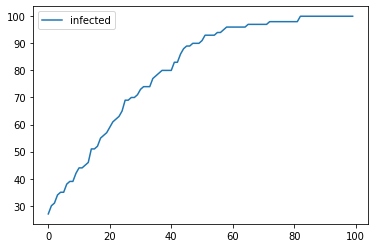

In [253]:
_ = m_df.plot.line(y='infected')

In [254]:
a_df = model.datacollector.get_agent_vars_dataframe()
a_df

state      speed   heading  time_infected
Step AgentID                                                      
0    0        State.UNAFFECTED  10.000000  4.640438       0.000000
     1        State.UNAFFECTED  10.000000  3.581081       0.000000
     2        State.UNAFFECTED  10.000000  1.888181       0.000000
     3          State.INFECTED  10.000000  0.114089       6.637078
     4        State.UNAFFECTED  10.000000  3.581158       0.000000
...                        ...        ...       ...            ...
99   95         State.INFECTED   8.213004  1.825408      55.000000
     96         State.INFECTED   3.863521  9.441917     101.808896
     97         State.INFECTED  18.023841 -0.863920      71.000000
     98         State.INFECTED  15.586600 -7.273329     106.243323
     99         State.INFECTED -30.623079  2.015952      90.000000

[10000 rows x 4 columns]

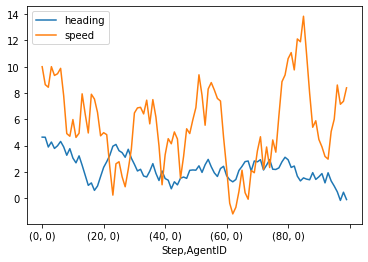

In [255]:
_ = a_df[a_df.index.get_level_values('AgentID') == 0].plot.line(y=['heading', 'speed'])

## Visualization

In [190]:
def plot_states_bokeh(model, iteration, total):
    X = model.datacollector.get_model_vars_dataframe()
    source = ColumnDataSource(X)
    colors = Category10[10]
    items = []
    p = figure(plot_width=600, plot_height=400, tools=[], title=f'step: {iteration}', x_range=(0,total))        
    for i, c in enumerate(X.columns):
        line = Line(x='index', y=c, line_color=colors[i], line_width=3, line_alpha=.8, name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c, [glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right', items=items))
    p.background_fill_color = "#ffffff"
    p.background_fill_alpha = 1
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

In [182]:
def plot_agents_bokeh(model):
    def plot_agents(p, agents, color):
        xx = list(map(lambda x: x.pos[0], agents))
        yy = list(map(lambda x: x.pos[1], agents))
        ss = list(map(lambda x: x.infection_radius, agents))
        p.circle_dot(x=xx, y=yy, size=ss, alpha=0.5, fill_color=color)
    
    agents = model.schedule.agents
    w = model.grid.width
    h = model.grid.height
    p = figure(plot_width=500, plot_height=500, x_range=(0, w), y_range=(0, h))
    
    plot_agents(p, list(filter(lambda x: x.state == State.INFECTED, agents)), "red")
    plot_agents(p, list(filter(lambda x: x.state == State.UNAFFECTED, agents)), "blue")
    plot_agents(p, list(filter(lambda x: x.state == State.RECOVERED, agents)), "green")
    
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

In [256]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane, grid_pane, sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

## Run simulation

In [257]:
model = EpidemicModel(
    N=100,
    initial_infection_p=.2,
    infection_p=.5,
    infection_r=30,
    infection_time_min=30,
    infection_end_p=0.7,
    death_p=0.6,
    initial_speed=10
)

TOTAL = 200
for i in range(TOTAL):
    model.step()
    plot_pane.object = plot_states_bokeh(model, i, TOTAL)
    grid_pane.object = plot_agents_bokeh(model)

### Ex. 5. Add death & recovery
- Add agent's recovery or death after some number of iterations (use `time_infected` parameter)
- Add death/recovered metric

# Batch running

In [208]:
fixed_params = {
    'N': 100,
    'infection_p': 0.5,
    'infection_r': 30,
    'infection_time_min': 30,
    'infection_end_p': 0.7,
    'initial_speed': 10
}

variable_params = {
    'initial_infection_p': np.arange(0.1, 1, 0.1),
    'death_p': np.arange(0.1, 1, 0.1)
}

batch_run = BatchRunner(
    EpidemicModel,
    variable_params,
    fixed_params,
    iterations=3,
    max_steps=100,
    model_reporters={
        'alive': compute_alive,
        'sick': compute_sick,
        'dead': compute_dead,
        'recovered': compute_recovered
    }
)

batch_run.run_all()

243it [00:32,  7.52it/s]


In [209]:
vars_df = batch_run.get_model_vars_dataframe()

In [210]:
vars_df

,initial_infection_p,death_p,Run,alive,dead,recovered,sick,N,infection_p,infection_r,infection_time_min,infection_end_p,initial_speed
0,0.1,0.1,0,93,7,69,13,100,0.5,30,30,0.7,10
1,0.1,0.1,1,89,11,58,8,100,0.5,30,30,0.7,10
2,0.1,0.1,2,93,7,39,25,100,0.5,30,30,0.7,10
3,0.1,0.2,3,88,12,64,4,100,0.5,30,30,0.7,10
4,0.1,0.2,4,88,12,49,12,100,0.5,30,30,0.7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.9,0.8,238,23,77,20,0,100,0.5,30,30,0.7,10
239,0.9,0.8,239,29,71,23,0,100,0.5,30,30,0.7,10
240,0.9,0.9,240,22,78,16,0,100,0.5,30,30,0.7,10
241,0.9,0.9,241,11,89,9,0,100,0.5,30,30,0.7,10


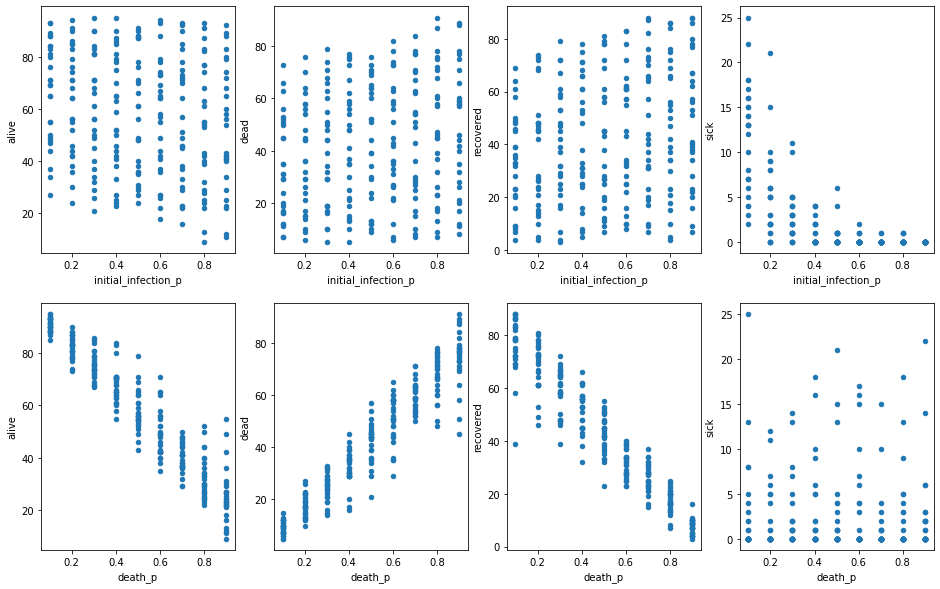

In [222]:
input_vars=variable_params.keys()
output_vars=['alive', 'dead', 'recovered', 'sick']

fig, ax = plt.subplots(len(input_vars), len(output_vars), figsize=(16, 10))
for i, o in itertools.product(enumerate(input_vars), enumerate(output_vars)):
    i_idx, i_val = i
    o_idx, o_val = o
    vars_df.plot.scatter(x=i_val, y=o_val, ax=ax[i_idx, o_idx])